# Evaluation

In [1]:
import os
import pickle
import shap
import skopt
import numpy as np
import pandas as pd
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from skopt import plots
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [2]:
output_data_path = os.path.join("..", "data", "final")
models_data_path = os.path.join("..", "data", "models")

## 1. Bayesian search results 

In [3]:
results = skopt.load(os.path.join(output_data_path, 'gp_optim_results.pkl'))

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

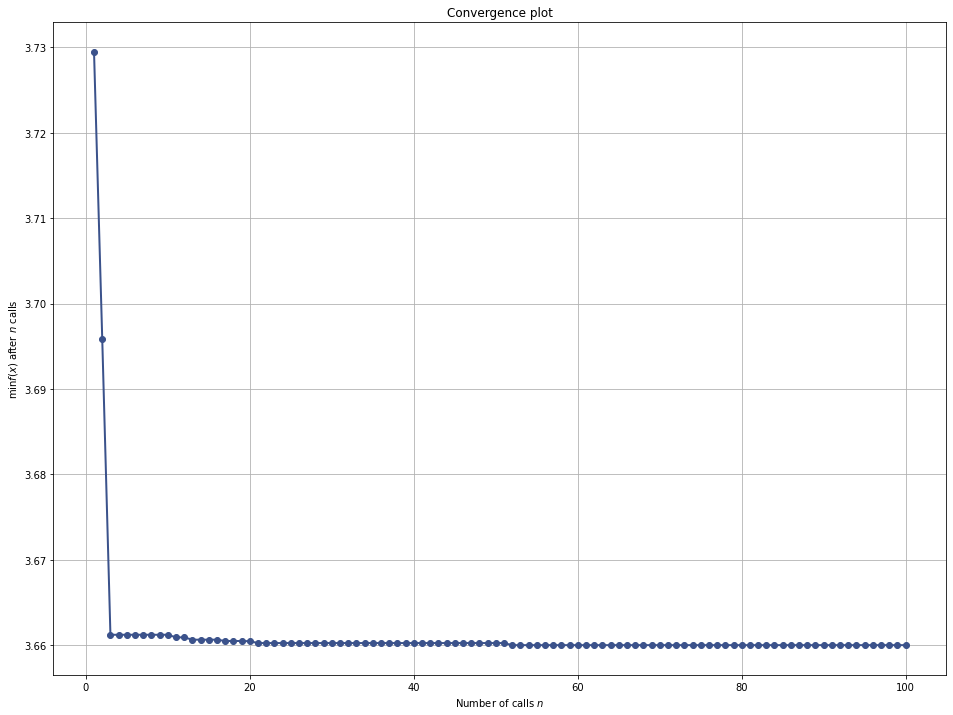

In [4]:
fig, ax = plt.subplots(figsize=(16,12))
plots.plot_convergence(results, ax=ax)

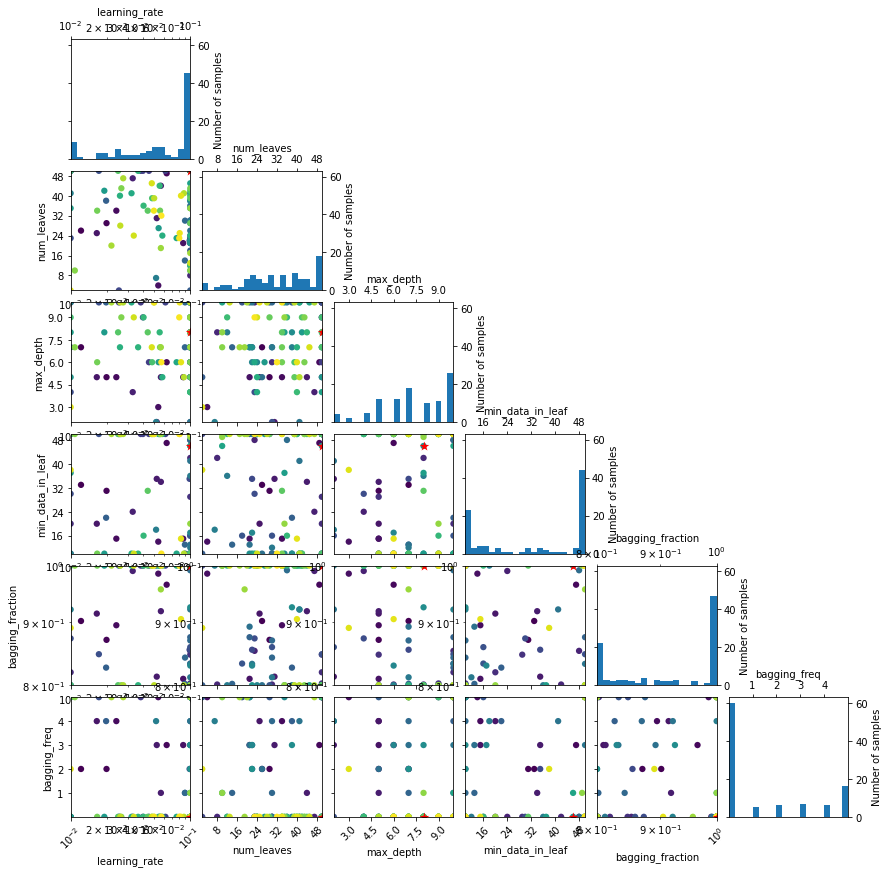

In [5]:
ax = plots.plot_evaluations(results)

## 2. Final model

Final model is going to be trained with parameters found by Bayesian optimization

In [6]:
opt_params = {}
param_names = ['learning_rate', 'num_leaves', 'max_depth',
               'min_data_in_leaf', 'bagging_fraction', 'bagging_freq']

for i, name in enumerate(param_names):
  opt_params[name] = results['x'][i]


In [7]:
static_params = {
    'objective': 'regression',
    'metric': 'l2',
    'boosting': 'gbdt',
    'random_state': 42,
    'verbosity': 0
}

In [8]:
params = {**static_params, **opt_params}

In [9]:
x = pd.read_csv(os.path.join(output_data_path, 'x_train.csv'))
y = pd.read_csv(os.path.join(output_data_path, 'y_train.csv'))

In [10]:
clfs = []
cv_score = np.zeros(len(y))
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for fold, (train_idx, valid_idx) in enumerate(kf.split(x, y)):
  x_train, y_train = x.values[train_idx], y.values[train_idx]
  x_valid, y_valid = x.values[valid_idx], y.values[valid_idx]
  y_train = y_train.ravel()
  y_valid = y_valid.ravel()
  lgb_train = lgb.Dataset(x_train, y_train)
  lgb_valid = lgb.Dataset(x_valid, y_valid)
  
  clf = lgb.train(params,
                  lgb_train,
                  num_boost_round=1000,
                  valid_sets=lgb_valid,
                  early_stopping_rounds=5)
  
  cv_score[valid_idx] = clf.predict(x_valid, num_iteration=clf.best_iteration)
  clf.save_model(os.path.join(models_data_path, 'sfmodel_fold_{}.txt').format(fold + 1), num_iteration=clf.best_iteration)

    
cv_score = [np.expm1(i) for i in cv_score]
y = [np.expm1(i) for i in y.values]
score = mean_squared_error(y, cv_score)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's l2: 0.152926
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l2: 0.131266
[3]	valid_0's l2: 0.113698
[4]	valid_0's l2: 0.0994013
[5]	valid_0's l2: 0.0878132
[6]	valid_0's l2: 0.0783893
[7]	valid_0's l2: 0.070722
[8]	valid_0's l2: 0.0644739
[9]	valid_0's l2: 0.0593537
[10]	valid_0's l2: 0.0551557
[11]	valid_0's l2: 0.0517455
[12]	valid_0's l2: 0.048962
[13]	valid_0's l2: 0.0466527
[14]	valid_0's l2: 0.0447747
[15]	valid_0's l2: 0.0432232
[16]	valid_0's l2: 0.0419498
[17]	valid_0's l2: 0.0408711
[18]	valid_0's l2: 0.0399753
[19]	valid_0's l2: 0.0392422
[20]	valid_0's l2: 0.038638
[21]	valid_0's l2: 0.0381317
[22]	valid_0's l2: 0.037709
[23]	valid_0's l2: 0.0373388
[24]	valid_0's l2: 0.0370337
[25]	valid_0's l2: 0.0367762
[2

In [11]:
np.sqrt(score)

1.912920408330365

## 3. Evaluation on test dataset

In [12]:
x_test = pd.read_csv(os.path.join(output_data_path, 'x_test.csv'))
y_test = pd.read_csv(os.path.join(output_data_path, 'y_test.csv'))

In [13]:
predicted = np.zeros(len(y_test))

for model in os.listdir(models_data_path):
  clf = lgb.Booster(model_file=os.path.join(models_data_path, model))
  predicted += clf.predict(x_test.values) / 10

In [14]:
predicted = [np.expm1(i) for i in predicted]
y_test = [np.expm1(i) for i in y_test.values]

In [15]:
np.sqrt(mean_squared_error(y_test, predicted))

1.8959760073663088

In [16]:
y_test = np.array(y_test).flatten()

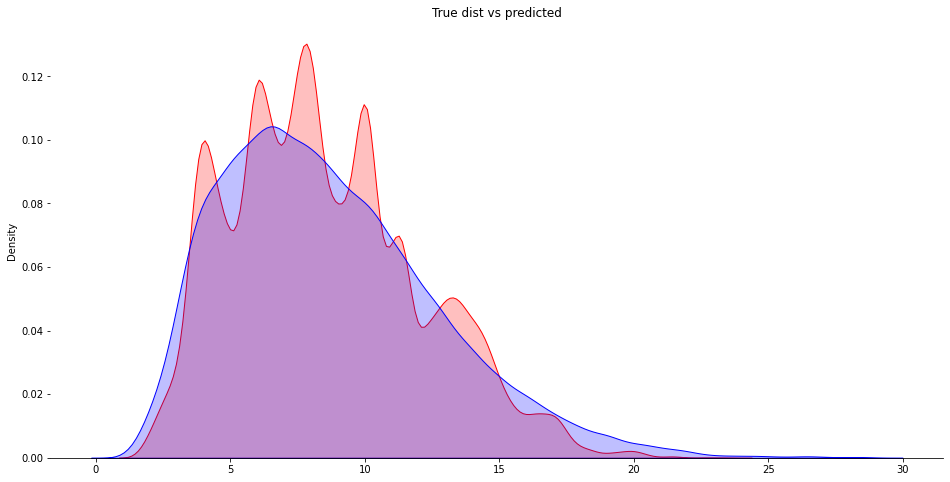

In [17]:
plt.figure(figsize=(16, 8))
plt.title('True dist vs predicted')
sns.kdeplot(predicted, shade=True, color='r', label='predicted')
sns.kdeplot(y_test, shade=True, color='b', label='true')
sns.despine(left=True)

## 4. SHAP

In [18]:
model = lgb.Booster(model_file=os.path.join(models_data_path, 'sfmodel_fold_1.txt'))
model.params["objective"] = "regression"
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test)

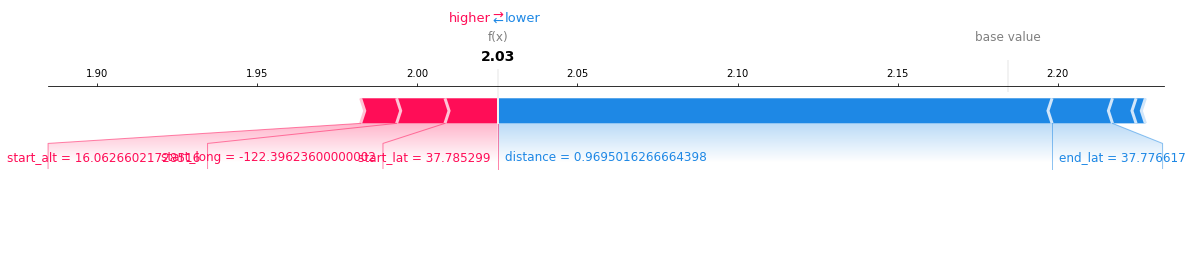

In [19]:
shap.force_plot(explainer.expected_value, shap_values[0,:], x_test.iloc[0,:], matplotlib=True)

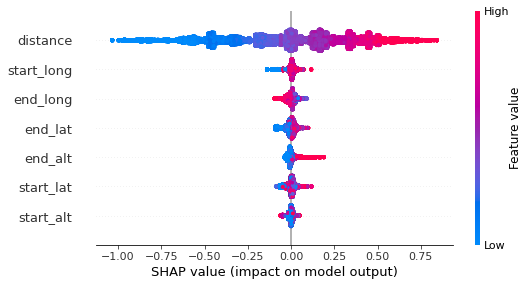

In [20]:
shap.summary_plot(shap_values, x_test)

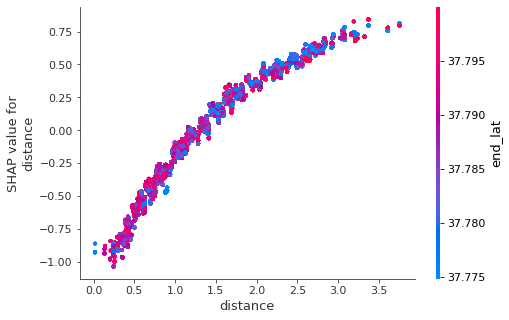

In [21]:
shap.dependence_plot('distance', shap_values, x_test)

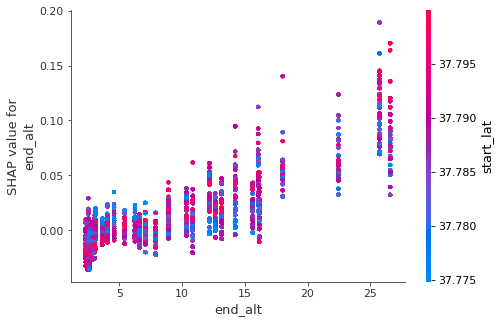

In [22]:
shap.dependence_plot('end_alt', shap_values, x_test)

## 5. Feature importances

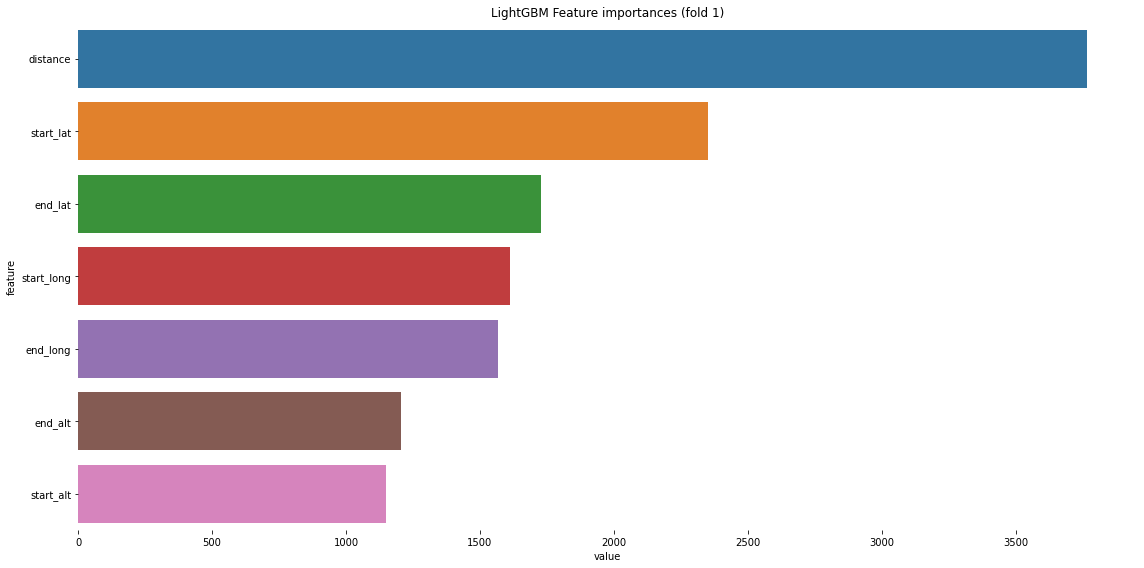

In [23]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importance(), x_test.columns)), columns=['value', 'feature'])
plt.figure(figsize=(16, 8))
sns.barplot(x='value', y='feature', data=feature_imp.sort_values(by='value', ascending=False))
sns.despine(left=True, bottom=True)
plt.title('LightGBM Feature importances (fold 1)')
plt.tight_layout()